# MOM6 Input Files for anu-tub

This case is designed to run MOM6 with the tub sector domain, at 0.25° resolution. 

The input files are saved in netcdf format, and need to copied into the relevant input directories before the run.

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

## Set up domain size and parameters

In [17]:
REa=6.37*10**6     # Radius of Earth
D = 4000           # Water depth
nx = 160           # number of gridpoints in x, y and z
ny = 800
nz = 75
rx = 0.25           # base resolution, in degrees

## Now, to make the horizontal grid - Mercator projection

In [59]:
dy = np.zeros(ny,)           # grid length
y = np.zeros(ny,)            # grid points
Ystart=-70.275597151116
dy[0] = rx
y[0] = Ystart + 0.5*rx*np.cos(Ystart*np.pi/180.)
for i in range(ny-1):
    y[i+1] = y[i] + dy[i]
    dy[i+1] = rx*np.cos(y[i+1]*np.pi/180.)

Yend = y[-1] + dy[-1]/2
print(' Domain goes from:',Ystart, ' to:', Yend)

# longitudinal grid is a bit easier.
dx = np.ones(nx,)*rx
x = np.cumsum(dx)-dx/2

# Make a mesh of grids.
X,Y = np.meshgrid(x,y)
#DX,DY = np.meshgrid(dx,dy)

#diff = Yend + Ystart
#print(diff)

 Domain goes from: -70.275597151116  to: 70.27559715111718


## Now make land and bathymetry

In [130]:
## make land:
dc=59
h = - D*(2**(-0.4*X**2)*(1-0.5*2**(-0.003*abs(-Y-dc)**4)) - 0.9)/0.9
h = h - D*(2**(-0.4*(X-nx*rx)**2)*(1-0.5*2**(-0.003*abs(-Y-dc)**4)) - 0.9)/0.9 - D
h = np.where(h<0,0,h)

## add in southern shelf
shelf_depth = 800
sws = 3   ## shelf width scale in degrees
htmp = D*np.ones(h.shape)
htmp = np.where((Y<Ystart+sws),shelf_depth*(1+(Y-(Ystart+sws))**3/(sws**3)),htmp)
htmp = np.where((Y>=Ystart+sws)&(Y<Ystart+2*sws),shelf_depth+(D-shelf_depth)/2*(Y-(Ystart+sws))**3/(sws**3),htmp)
htmp = np.where((Y>=Ystart+2*sws)&(Y<Ystart+3*sws),D+(D-shelf_depth)/2*(Y-(Ystart+3*sws))**3/(sws**3),htmp)
h = np.where(h<htmp,h,htmp);



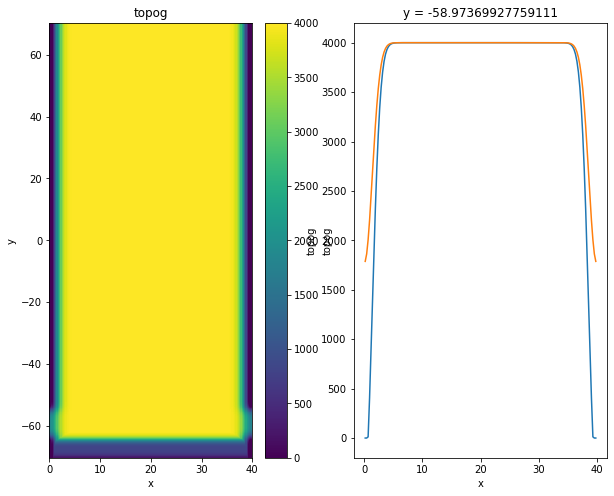

In [131]:
hda  = xr.DataArray(h, 
                  coords=[('y', y),('x', x)], 
                  name='topog',)

hda.to_netcdf('topog.nc')

# plot for posterity
plt.figure(figsize=(10,8))
plt.subplot(121)
hda.plot()
plt.title('topog')

plt.subplot(122)
hda.sel(y=10,method='nearest').plot()
hda.sel(y=-59,method='nearest').plot()


# Now construct wind stress forcing
For now, just make reference case.


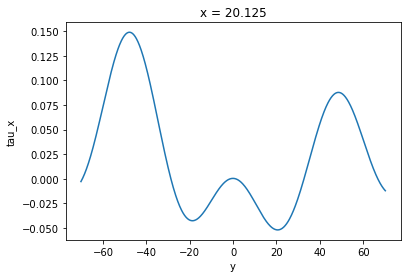

In [135]:
# Wind stress

tau_x = 0.03*(np.cos(4*2*np.pi*Y/180) - 1 + 5.1*np.exp(-((Y+50)/20)**2) + 3.2*np.exp(-((Y-53)/20)**2))

#tau_x = (0.034*(np.cos(8*np.pi*Y/180) - 1  + 3.5*np.exp(-((Y-51.5)/24.2)**2)))*np.tanh((Y/25))**2
tau_y = tau_x*0.0

tau_ds = xr.Dataset({'tau_x': (['y', 'x'],  tau_x),
                     'tau_y': (['y', 'x'], tau_y),
                     'SSS': (['y', 'x'], np.zeros((ny,nx))),
                     'LW': (['y', 'x'], np.zeros((ny,nx))),
                     'SW': (['y', 'x'], np.zeros((ny,nx))),
                     'froz_precip': (['y', 'x'], np.zeros((ny,nx))),
                     'froz_runoff': (['y', 'x'], np.zeros((ny,nx))),
                     'latent': (['y', 'x'], np.zeros((ny,nx))),
                     'liq_precip': (['y', 'x'], np.zeros((ny,nx))),
                     'liq_runoff': (['y', 'x'], np.zeros((ny,nx))),
                     'sensible': (['y', 'x'], np.zeros((ny,nx))),
                     'evap': (['y', 'x'], np.zeros((ny,nx)))},
                     coords={'x': (['x'], x),'y': (['y'], y)},)

#plot
tau_ds.tau_x.sel(x=20,method='nearest').plot()

tau_ds.to_netcdf('forcing.nc')

# Construct SST relaxation file
The SST relaxation is an analytical form based on NOCS climatology, and used in previous thce experiments. We only make one SST file; buoyancy flux can be varied by changing either the diffusivity or restoring timescale, or can be simply switched off.

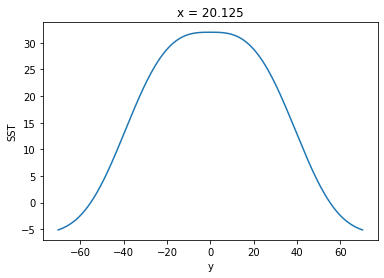

In [136]:
sst =  38*np.exp((-np.abs(Y)/45)**3) - 6

sstda  = xr.DataArray(sst, 
                  coords=[('y', y),('x', x)], 
                  name='SST',)

sstda.to_netcdf('sst.nc')

#plot
sstda.sel(x=20,method='nearest').plot()